In [ ]:
!pip install catboost

In [107]:
# Standard python libraries
from google.colab import drive
import os
import sys
import time
import yaml
import joblib
from functools import partial
import warnings
warnings.filterwarnings('ignore')
# Essential DS libraries
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, roc_curve,roc_auc_score,average_precision_score,auc,accuracy_score
from sklearn.calibration import CalibratedClassifierCV,CalibrationDisplay,calibration_curve

import scipy.stats as sps
import shap
from catboost import CatBoostClassifier, Pool, cv, EFstrType

In [108]:
def binary_model_metric_perfomance(model,pool,threshold=0.5):

#     получение предсказаний на automl lama model по датасету и reshape чтобы получить вектор
    pred_proba = model.predict_proba(pool)[:,1].reshape(-1)
    pred = (pred_proba >= threshold).astype(int)

    pred_distrib = np.unique(pred,return_counts=True)

    target = pool.get_label()
    target_distrib = np.unique(target,return_counts=True)

    target_classes = {f"target_label_count_{target_distrib[0][i]}" : target_distrib[1][i] for i in range(len(target_distrib[0]))}
    pred_classes = {f"pred_label_count_{pred_distrib[0][i]}" : pred_distrib[1][i] for i in range(len(pred_distrib[0]))}


    binary_metrics = {
            'N': len(pred),
            'accuracy' : accuracy_score(target,pred),
            'precision' : precision_score(target,pred),
            'recall' : recall_score(target,pred),
            'f1' : f1_score(target,pred),
            'roc-auc' : roc_auc_score(target,pred_proba),
            'gini' : 2 * roc_auc_score(target,pred_proba) - 1,
            'pr-auc' : average_precision_score(target,pred_proba),
            'threshold' : threshold,
        }

    binary_metrics.update(target_classes)
    binary_metrics.update(pred_classes)

    return binary_metrics

def gini_di(nn, na, gini, auc, alpha=0.05):
    '''https://newtechaudit.ru/gini-coefficient/'''
    n= nn+na # nn – число «позитивных» наблюдений, na -  число «негативных»
    q1 = auc/(2-auc)# блоки формулы из статьи
    q2 = (2*auc**2)/(1+auc) # блоки формулы из статьи
    #стандартное отклонение Джини
    sigma = (np.sqrt((auc*(1-auc)+(na-1)*(q1-auc**2)+(nn-1)*(q2-auc**2))/(na*nn)))*2
    return ((abs(sps.t.ppf(alpha/2, n-1))*sigma)).round(4)

def test_m4(pred,target):
    P = np.mean(pred)
    TR = np.mean(target)

    relevant_diff = round(abs(P - TR) / TR,4)

    if relevant_diff >= 0.2:
        flag = 'red'
    elif relevant_diff < 0.2 and relevant_diff > 0.1:
        flag = 'yellow'
    else:
        flag = 'green'

    return {'relevant_diff':relevant_diff,'flag':flag}


def test_m5_1(train_pred,train_label,test_pred,test_label):

    train_nn,train_na = np.unique(train_label,return_counts=True)[1]
    test_nn,test_na = np.unique(test_label,return_counts=True)[1]

    auc_train = roc_auc_score(train_label,train_pred)
    gini_train = round(2 * auc_train - 1,4)
    auc_test = roc_auc_score(test_label,test_pred)
    gini_test = round(2 * auc_test - 1,4)

    abs_diff = round(gini_test - gini_train,4)
    relevant_diff = round(abs(abs_diff / gini_train),4)

    gini_train_di = gini_di(train_nn, train_na, gini_train, auc_train)
    gini_test_di = gini_di(test_nn, test_na, gini_test, auc_test)

    # plot gini bar
    plt.bar(['gini_train','gini_test'], [gini_train,gini_test], yerr=[gini_train_di,gini_test_di],width = 0.5, capsize=15)
    plt.text(0,gini_train,gini_train)
    plt.text(1,gini_test,gini_test)
    plt.ylabel('gini')
    plt.title('Gini of models on samples')
    plt.show()

    if relevant_diff >= 0.2:
        flag = 'red'
    elif relevant_diff < 0.2 and relevant_diff > 0.15:
        flag = 'yellow'
    else:
        flag = 'green'

    return {'relevant_diff':relevant_diff, 'abs_diff':abs_diff,'flag':flag}



# Загрузка данных и конфига и модели

In [109]:
if 'drive' not in os.listdir():
    drive.mount('/content/drive')
# основные пути и файлы
working_path = '/content/drive/MyDrive/risk_project_1'
data_path = os.path.join(working_path,'data')
model_path = os.path.join(working_path,'models')
model_name = 'simple_catboost.pkl'

train_file = 'catboost_train.csv'
oos_file = 'catboost_oos.csv'
oot_file = 'catboost_oot.csv'
config_file = 'catboost_data_config.yml'
# конфиг датасета
with open(os.path.join(working_path,config_file),'r',encoding='utf-8') as config:
    data_config = yaml.full_load(config)

# данные
train = pd.read_csv(os.path.join(data_path,train_file)).fillna(dict(zip(data_config['roles']['category'],['None'] * len(data_config['roles']['category']))))
train_pool = Pool(train.drop(columns = data_config['roles']['drop'] + [data_config['roles']['target']]),
                  label=train[data_config['roles']['target']],
                  cat_features=data_config['roles']['category'])

oos = pd.read_csv(os.path.join(data_path,oos_file)).fillna(dict(zip(data_config['roles']['category'],['None'] * len(data_config['roles']['category']))))
oos_pool = Pool(oos.drop(columns = data_config['roles']['drop'] + [data_config['roles']['target']]),
                  label=oos[data_config['roles']['target']],
                  cat_features=data_config['roles']['category'])

oot = pd.read_csv(os.path.join(data_path,oot_file)).fillna(dict(zip(data_config['roles']['category'],['None'] * len(data_config['roles']['category']))))
oot_pool = Pool(oot.drop(columns = data_config['roles']['drop'] + [data_config['roles']['target']]),
                  label=oot[data_config['roles']['target']],
                  cat_features=data_config['roles']['category'])

model = joblib.load(os.path.join(model_path,model_name))

# Предсказания для всех выборок

In [110]:
target = data_config['roles']['target']

train_pred = model.predict_proba(train_pool)[:,1]
oos_pred = model.predict_proba(oos_pool)[:,1]
oot_pred = model.predict_proba(oot_pool)[:,1]

# Пункт А - дискретизация предсказаний
Для дискредитаци предсказании отберем порог по train

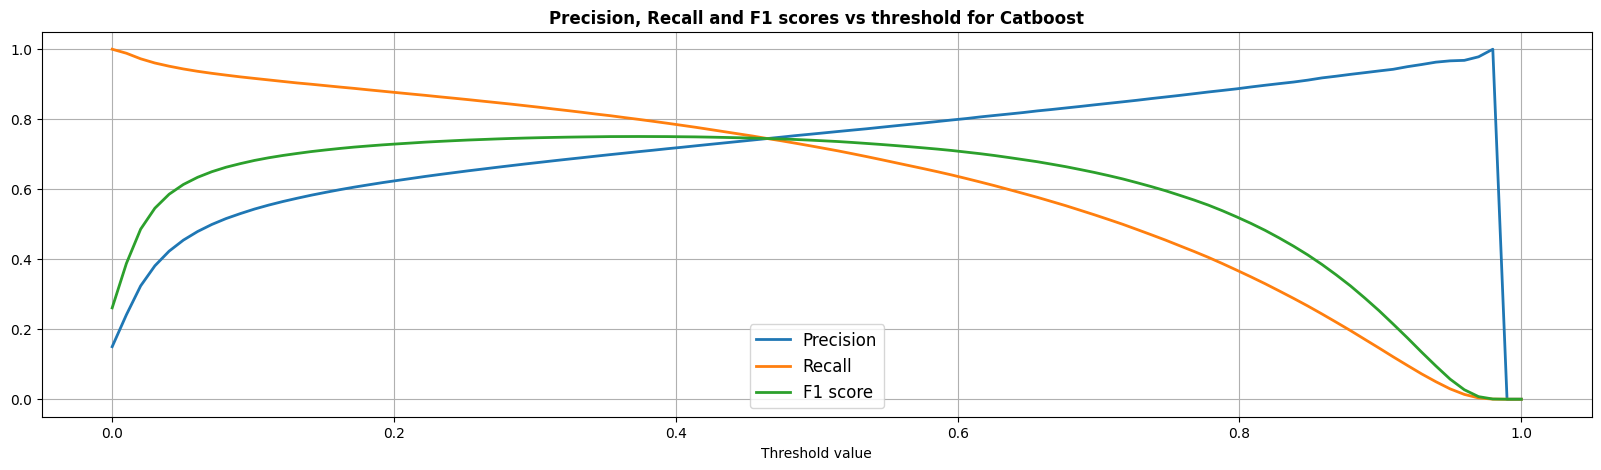

In [111]:
tr = np.linspace(0, 1, 100)

p = np.zeros_like(tr)
r = np.zeros_like(tr)
f = np.zeros_like(tr)

for k, x in enumerate(tr):
    p[k] = precision_score(train_pool.get_label(),(train_pred >= x).astype(int))
    r[k] = recall_score(train_pool.get_label(),(train_pred >= x).astype(int))
    f[k] = f1_score(train_pool.get_label(),(train_pred >= x).astype(int))

best_thr = tr[np.argmax(f)]

fig = plt.figure(figsize=(20, 5))

plt.plot(tr, p, linewidth=2)
plt.plot(tr, r, linewidth=2)
plt.plot(tr, f, linewidth=2)

plt.title("Precision, Recall and F1 scores vs threshold for Catboost", weight="bold")
plt.xlabel("Threshold value")
plt.legend(['Precision', 'Recall', 'F1 score'], fontsize=12)
plt.grid()
plt.show()

# Пункт B - разделяющая способность модели

## Основные метрики модели

In [112]:
result_dict = {}
result_dict[f"train {target}"] = binary_model_metric_perfomance(model,train_pool,threshold=best_thr)
result_dict[f"oos {target}"] = binary_model_metric_perfomance(model,oos_pool,threshold=best_thr)
result_dict[f"oot {target}"] = binary_model_metric_perfomance(model,oot_pool,threshold=best_thr)

result_df = []

for k,v in result_dict.items():
    type_dataset = k.split()[0]
    target_col = ' '.join(k.split()[1:])
    res = {'dataset': type_dataset, 'measurement' : target_col,}
    res.update(v)
    result_df.append(res)

result_df = pd.DataFrame(result_df)
print('Метрики на всех выбироках для модели Catboost')
display(result_df)

Метрики на всех выбироках для модели Catboost


,dataset,measurement,N,accuracy,precision,recall,f1,roc-auc,gini,pr-auc,threshold,target_label_count_0,target_label_count_1,pred_label_count_0,pred_label_count_1
0,train,loan_condition_int,1298859,0.920288,0.707373,0.799492,0.750617,0.950399,0.900797,0.800450,0.373737,1103969,194890,1078589,220270
1,oos,loan_condition_int,432954,0.920033,0.707260,0.796903,0.749410,0.949277,0.898553,0.797037,0.373737,367990,64964,359756,73198
2,oot,loan_condition_int,298139,0.977588,0.591533,0.410712,0.484811,0.868542,0.737085,0.454247,0.373737,290484,7655,292824,5315


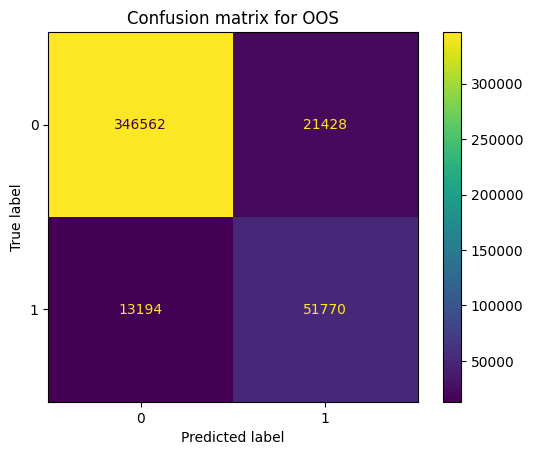

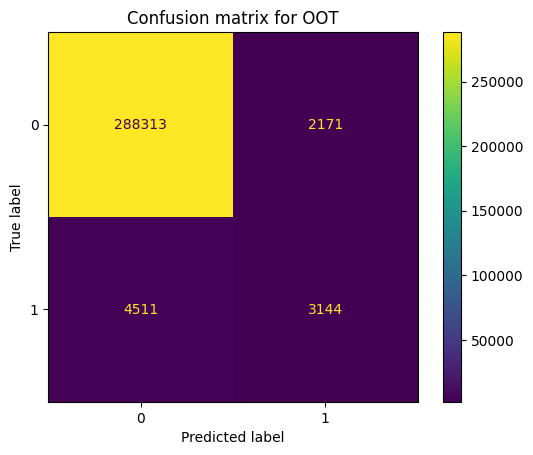

In [113]:
classes = [0,1]
predictions = (oos_pred >= best_thr).astype(int)
cm = confusion_matrix(oos_pool.get_label(), predictions, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)
disp.plot()
plt.title('Confusion matrix for OOS')
plt.show()

predictions = (oot_pred >= best_thr).astype(int)
cm = confusion_matrix(oot_pool.get_label(), predictions, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)
disp.plot()
plt.title('Confusion matrix for OOT')
plt.show()

## Сравнение прогнозного и фактического TR (Target Rate) на уровне выборки

In [114]:
result = test_m4(train_pred,train_pool.get_label())
print(f"Относительное снижение на train на {result['relevant_diff']} ==> {result['flag']} flag")

result = test_m4(oos_pred,oos_pool.get_label())
print(f"Относительное снижение на oos на {result['relevant_diff']} ==> {result['flag']} flag")

result = test_m4(oot_pred,oot_pool.get_label())
print(f"Относительное снижение на oot на {result['relevant_diff']} ==> {result['flag']} flag")

Относительное снижение на train на 0.0022 ==> green flag
Относительное снижение на oos на 0.0016 ==> green flag
Относительное снижение на oot на 0.3682 ==> red flag


# Пункт С - Переобучение модели

Между train и oot


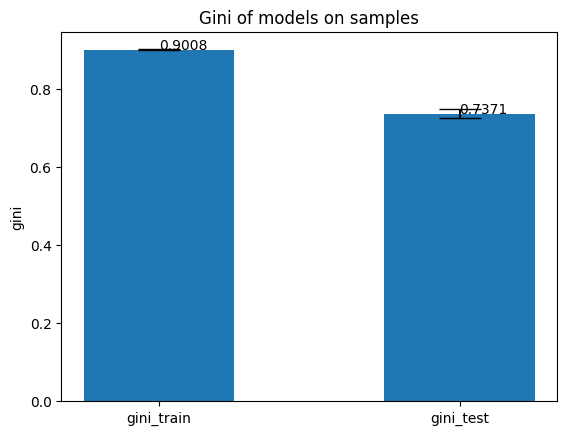

Относительное снижение на 0.1817 ==> yellow flag
Между train и oos


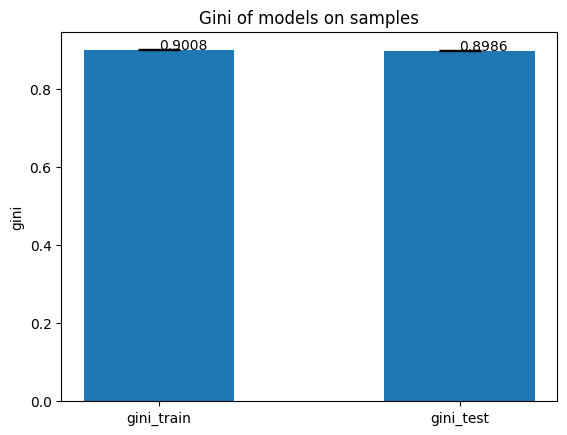

Относительное снижение на 0.0024 ==> green flag


In [115]:
print('Между train и oot')
result = test_m5_1(train_pred,train_pool.get_label(),oot_pred,oot_pool.get_label())
print(f"Относительное снижение на {result['relevant_diff']} ==> {result['flag']} flag")
print('Между train и oos')
result = test_m5_1(train_pred,train_pool.get_label(),oos_pred,oos_pool.get_label())
print(f"Относительное снижение на {result['relevant_diff']} ==> {result['flag']} flag")

# Пункт D - Простота модели

График значения функции потерь Cross Entropy во время отбора фичей, на котором видно, что мы избавились от большого числа фичей, так что можно думать, что наша бустинговая модель не слишком усложнена.

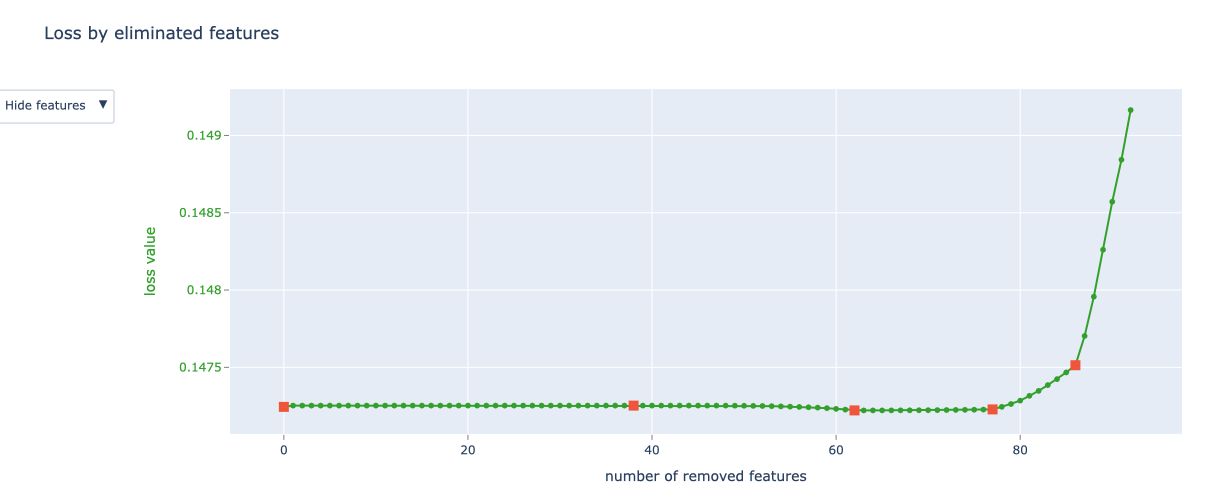

In [116]:
feature_importance = pd.DataFrame({'feature':train_pool.get_feature_names(),
                      'train_feature_importance' : model.get_feature_importance(data=train_pool,type=EFstrType.FeatureImportance),
                      'oot_feature_importance' : model.get_feature_importance(data=oot_pool,type=EFstrType.FeatureImportance),
                      'train_feature_importance_loss_change' : model.get_feature_importance(data=train_pool,type=EFstrType.LossFunctionChange),
                      'oot_feature_importance_loss_change' : model.get_feature_importance(data=oot_pool,type=EFstrType.LossFunctionChange),
})

In [117]:
feature_importance

,feature,train_feature_importance,oot_feature_importance,train_feature_importance_loss_change,oot_feature_importance_loss_change
0,addr_state,0.642884,0.931151,0.000127,-0.000039
1,all_util,1.327502,0.534199,0.000197,0.000152
2,annual_inc,1.535937,2.569168,0.000537,-0.000111
3,bc_open_to_buy,0.581401,0.879439,0.000087,0.000032
4,dti,1.612683,2.256622,0.000453,0.000054
5,emp_length,3.749389,7.432895,0.001080,-0.000487
6,fico_range_high,0.700800,1.046924,0.000095,0.000153
7,fico_range_low,0.989047,1.413574,0.000116,0.000187
8,funded_amnt,1.602886,2.097461,0.000306,-0.000108
9,funded_amnt_inv,1.712522,2.196872,0.000338,-0.000098


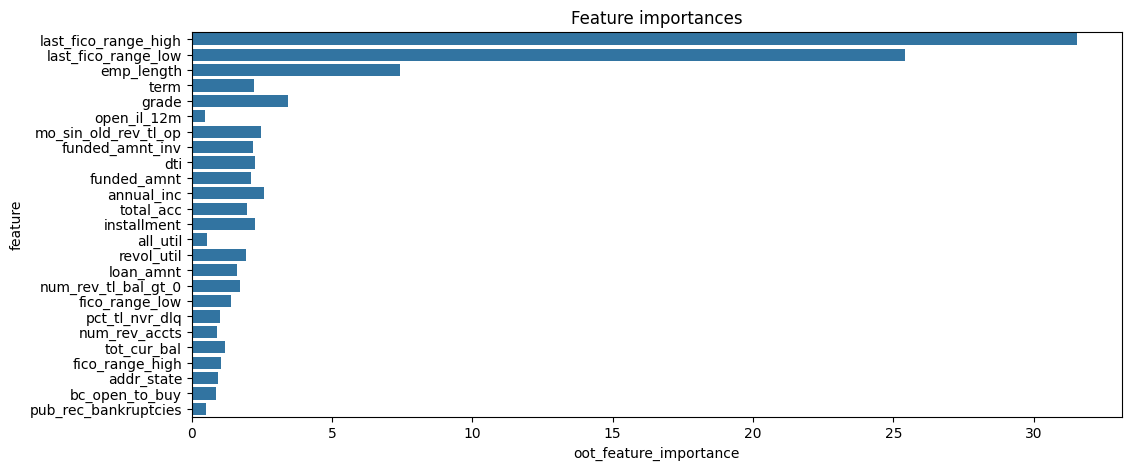

In [118]:
plt.figure(figsize=(12,5))
plt.title('Feature importances')
sns.barplot(x='oot_feature_importance', y='feature', data=feature_importance.sort_values(by='train_feature_importance',ascending=False))
plt.show()

# Пункт E - Устойчивость модели в динамике

Здесь смотрим на метрику только на OOS и OOT

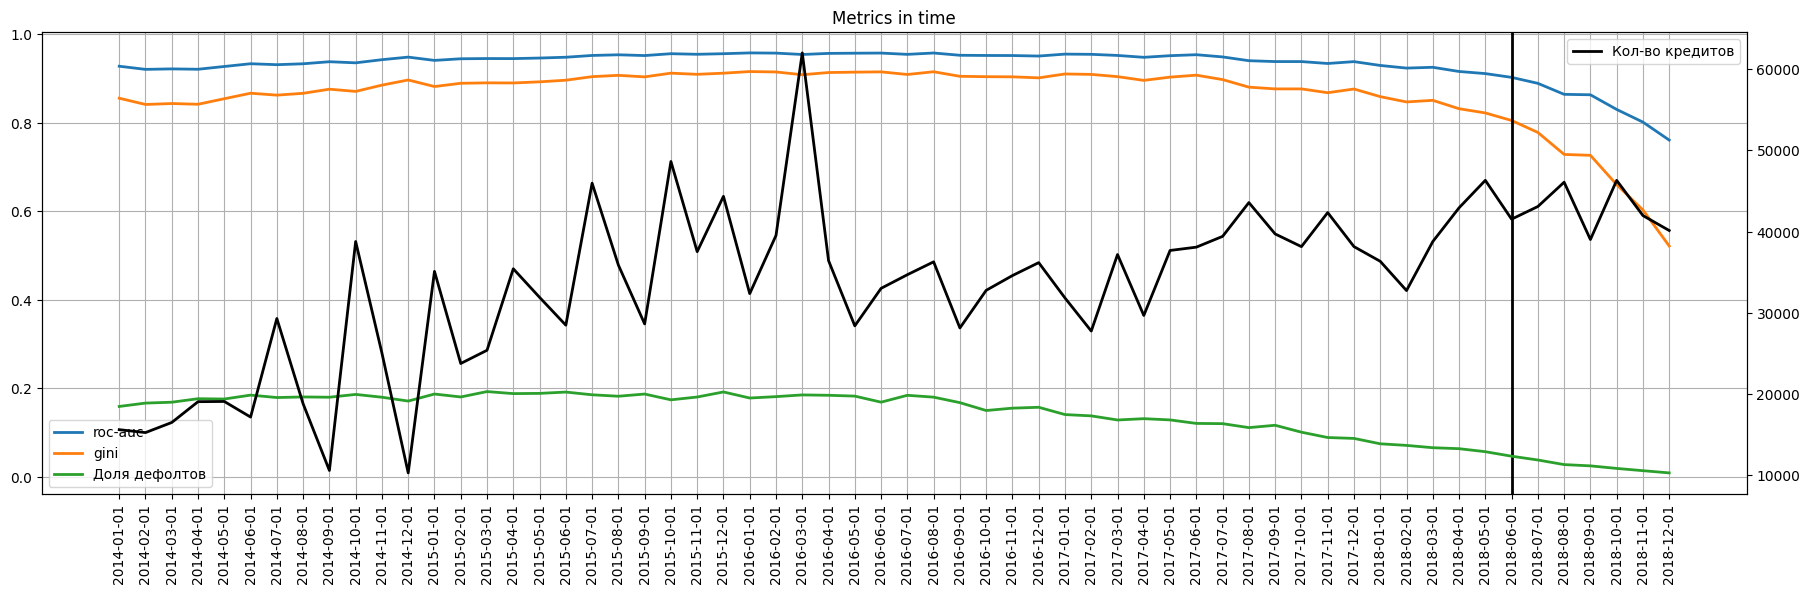

In [119]:
def metric_per_group(df,model,metric_name,thr):
    '''possible metric_name: accuracy, precision, recall, f1, roc-auc, pr-auc'''
    df_pool = Pool(df.drop(columns = data_config['roles']['drop'] + [data_config['roles']['target']]),
                  label=df[data_config['roles']['target']],
                  cat_features=data_config['roles']['category'])

    return binary_model_metric_perfomance(model,df_pool,threshold=thr)[metric_name]

dataset = pd.concat([train,oos,oot]).reset_index(drop=True)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
fig.set_size_inches(22,6)
for metric in ['roc-auc','gini']:
    score_in_time = dataset.groupby(data_config['time_col']).apply(partial(metric_per_group,
                                                                            **{"model":model,"metric_name":metric,"thr":best_thr}))
    ax1.plot(score_in_time, linewidth=2, label = metric)

ax1.axvline(str(pd.to_datetime(data_config['test_time_border']).date()), color='black', linewidth=2)
ax1.plot(dataset.groupby(data_config['time_col'])[target].mean(), linewidth=2, label = 'Доля дефолтов')
ax2.plot(dataset.groupby(data_config['time_col'])[target].count(), linewidth=2, label = 'Кол-во кредитов',c='black')
ax1.set_title('Metrics in time')
ax1.tick_params(axis="x", rotation=90)
ax1.grid()
ax1.legend()
ax2.legend()
plt.show()

# Пункт G - Корректность Оценки PD

## Roc-auc кривая для OOT

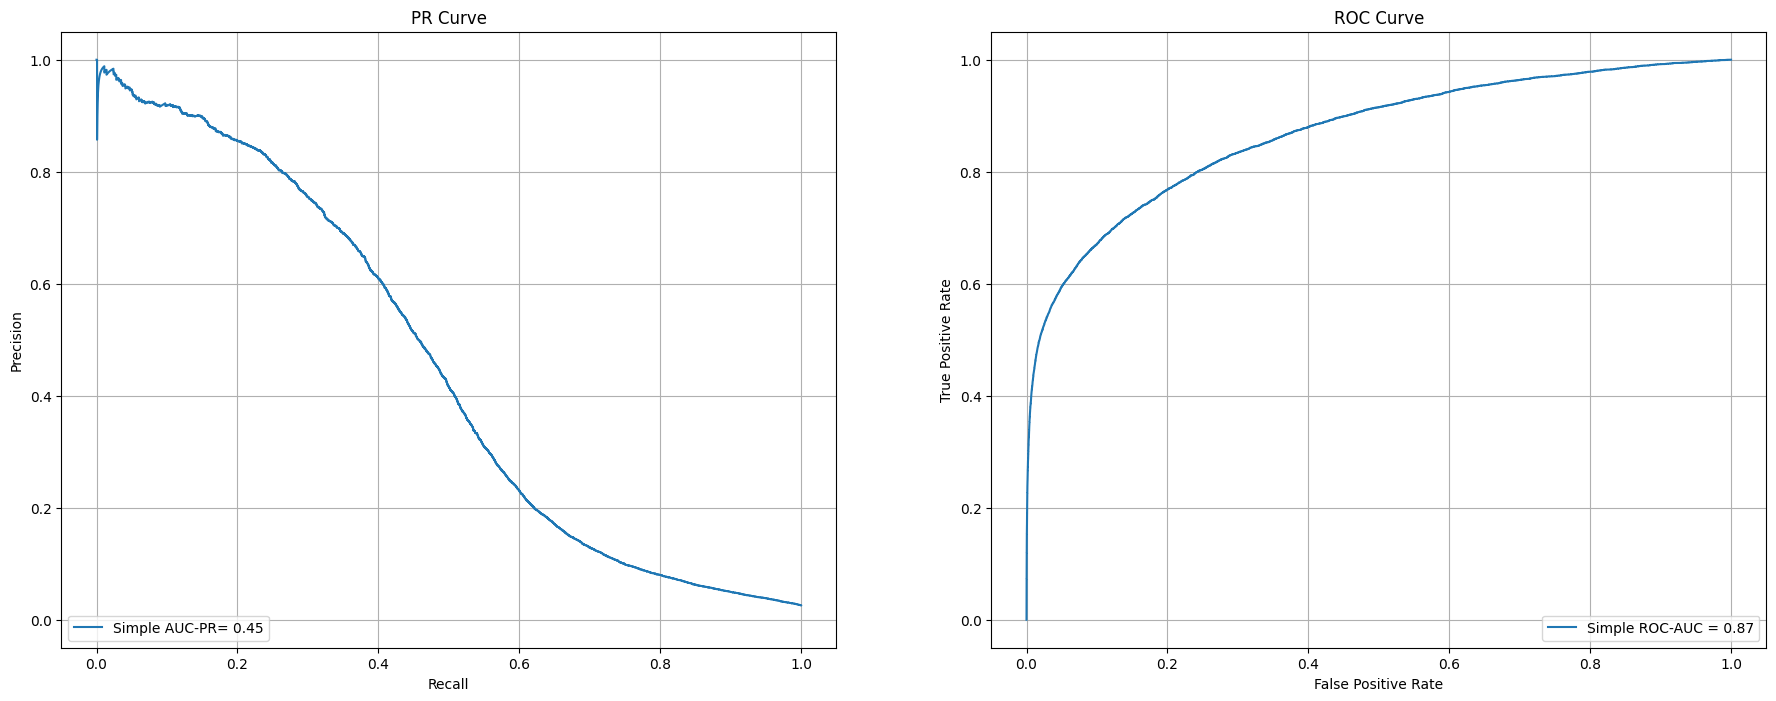

In [120]:
fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')


precision, recall, thresholds = precision_recall_curve(oot_pool.get_label(),oot_pred)
ap = auc(recall, precision)
ax1.plot(recall,precision, label = f'Simple AUC-PR= {round(ap,2)}')

fpr, tpr, thresholds = roc_curve(oot_pool.get_label(),oot_pred)
rocauc = roc_auc_score(oot_pool.get_label(),oot_pred)
ax2.plot(fpr,tpr, label = f'Simple ROC-AUC = {round(rocauc,2)}')

ax1.legend(loc='lower left')
ax2.legend(loc='lower right')
ax1.grid()
ax2.grid()
plt.show()

## Калибровочные кривые для OOT

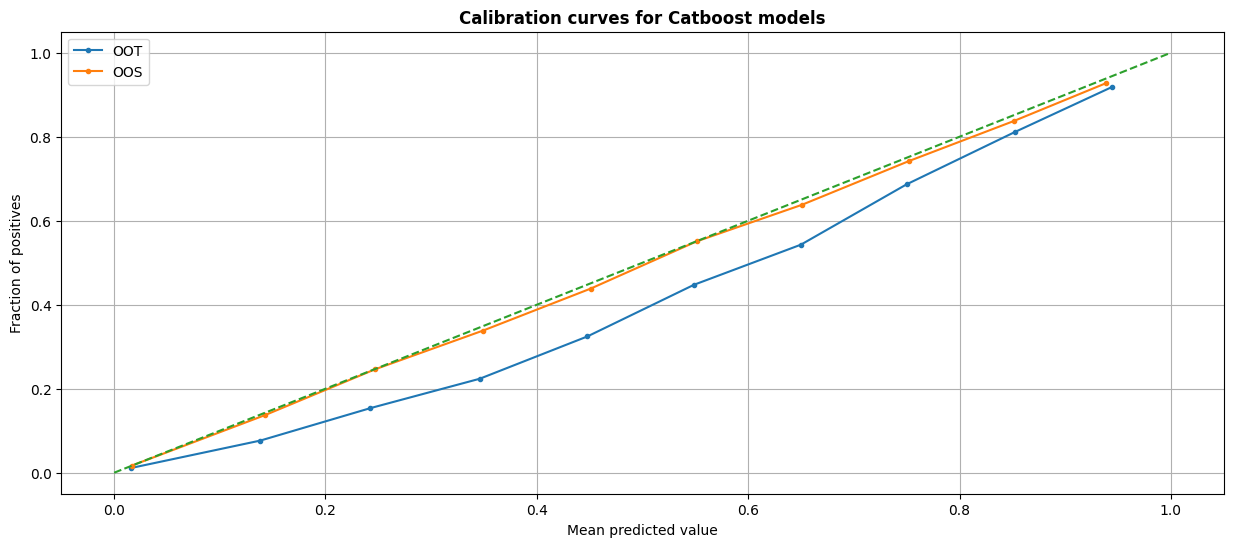

In [121]:
fig = plt.figure(figsize=(15, 6))

prob_true, prob_pred = calibration_curve(oot_pool.get_label(),oot_pred, n_bins=10,normalize=True,strategy='uniform')
plt.plot(prob_pred,prob_true, marker = '.',label = 'OOT')
prob_true, prob_pred = calibration_curve(oos_pool.get_label(),oos_pred, n_bins=10,normalize=True,strategy='uniform')
plt.plot(prob_pred,prob_true, marker = '.',label = 'OOS')

plt.plot([0, 1], [0, 1], linestyle = '--')
plt.title("Calibration curves for Catboost models", weight="bold")
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.legend()
plt.grid()
plt.show()

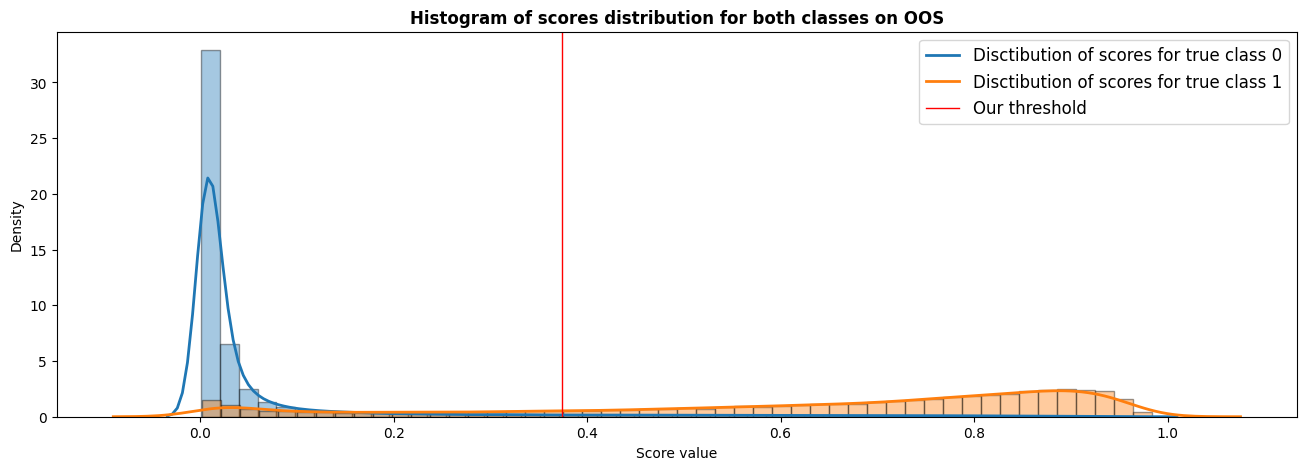

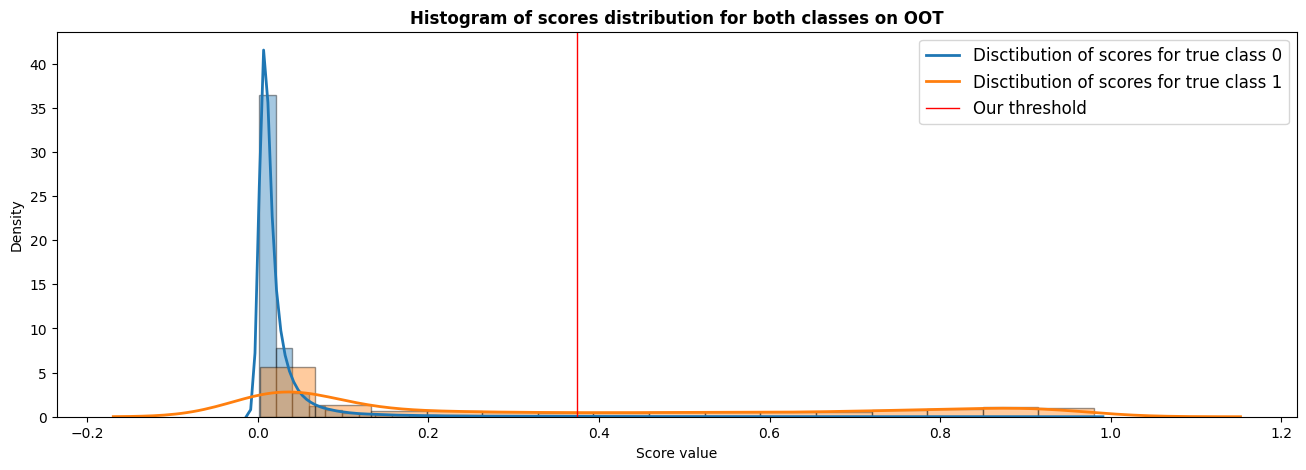

In [122]:
fig = plt.figure(figsize=(16, 5))

sns.distplot(oos_pred[oos_pool.get_label() == 0], hist=True, kde=True,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

sns.distplot(oos_pred[oos_pool.get_label() == 1], hist=True, kde=True,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

plt.axvline(best_thr, color='red', linewidth=1)

plt.title("Histogram of scores distribution for both classes on OOS", weight="bold")

plt.xlabel("Score value")

plt.legend([
    'Disctibution of scores for true class 0',
    'Disctibution of scores for true class 1',
    'Our threshold'],
    fontsize=12
)

plt.show()

fig = plt.figure(figsize=(16, 5))

sns.distplot(oot_pred[oot_pool.get_label() == 0], hist=True, kde=True,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

sns.distplot(oot_pred[oot_pool.get_label() == 1], hist=True, kde=True,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

plt.axvline(best_thr, color='red', linewidth=1)

plt.title("Histogram of scores distribution for both classes on OOT", weight="bold")

plt.xlabel("Score value")

plt.legend([
    'Disctibution of scores for true class 0',
    'Disctibution of scores for true class 1',
    'Our threshold'],
    fontsize=12
)

plt.show()